<a href="https://colab.research.google.com/github/Srivathshan-Paramalingam-0505/DMML2022_UNIL_Zoom/blob/main/Cloud_MicrosoftTeam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map Static API

The idea is to capture a part of a map and import a PNG image directly to our iOt device.

In [ ]:
import requests

In [ ]:
requests.get('https://maps.googleapis.com/maps/api/staticmap?center=46.522640192908185%2c%20-6.584987401404577&zoom=16&size=320x240&key=yourKey')

<Response [200]>

From Google Colab, we can use the Static Map API to generate an image from Google Maps, using parameters such as latitude, longitude, zoom, size and our API key.

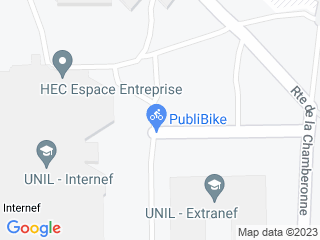

In [ ]:
import requests
from PIL import Image
from io import BytesIO

url = "https://maps.googleapis.com/maps/api/staticmap?center=46.522640192908185,6.584987401404577&zoom=18&size=320x240&key=yourKey"

response = requests.get(url)

if response.status_code == 200:
    # Access the response content in bytes
    content = response.content
    # Use PIL to open the image from the bytes
    image = Image.open(BytesIO(content))
    # Show the image in a new window
    image.show()
else:
    print("Failed to fetch URL")

In [ ]:
import requests
from PIL import Image
from io import BytesIO

url = "https://us-central1-projectiot-380815.cloudfunctions.net/FindLocation"

data = {
    "center": "46.522640192908185,6.584987401404577",
    "zoom": "18",
    "size": "320x240"
}

response = requests.post(url, data=data)

if response.status_code == 200:
    # Get the image from the response
    image_bytes = response.json().get("image")
    # Display with the image
    img = Image.open(BytesIO(image_bytes))
    img.show()
else:
    print("Error:", response.text)

When we tried to create a Google Cloud function to generate a specific image, we found out that it was too complex to retrieve image data directly into the m5stack core2.

(see "Cloud_Function_FindLocation.py" in our git)

Below, you can see an example calling the cloud function.



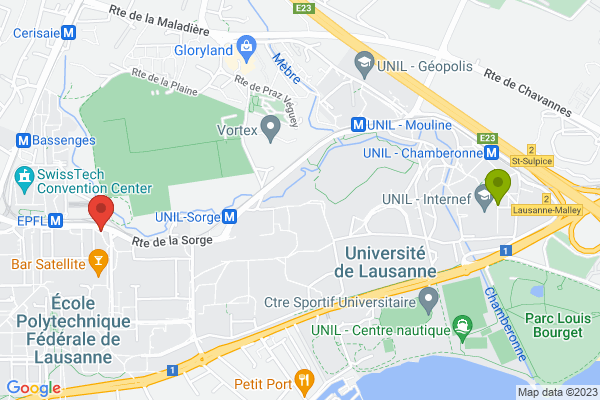

In [ ]:
import requests
from PIL import Image
from io import BytesIO

origin = "46.522640192908185, 6.584987401404577"
destination = "46.521880860162064, 6.567944879588675"
mode = "bicycling"
key = "yourKey"

#the curly braces are replaced by the variable values at runtime, using f-string
url = f"https://maps.googleapis.com/maps/api/staticmap?size=600x400&maptype=roadmap&markers=color:green|{origin}&markers=color:red|{destination}&key={key}"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
}

response = requests.get(url, headers=headers)

img = Image.open(BytesIO(response.content))
img.show()

##Issues with Map Static API

Using the API Key, we could display the location of PubliBike at UNIL without problem.

However, we are not able to retrieve directly an image from a Google Cloud function. We are stucked with a problem with the module base64 that is not recognized inside the function.

As the API uses an image in bytes, that module is used to decode the response of the server and display it in PNG. Currently, the server is not able to fulfil that request (http error 500).

# Maps Embed API

### Challenges with Maps Embed
The functionalities of that API could be useful for our project since we want to display directions from one place to another. Using the mode "directions" available in that API, we can choose an origin and a destination. Those parameters can be given in float format, representing a pair of (latitude, longitude) so we can directly retrieve these measures from our IoT core2 plugged with the GPS model.

Here are the current challenges to be solved to be able to use that API:

* As Maps Embed return an iFrame, which is a web tool, it doesn't generate directly an interactive image but the parameters required for a Website page, allowing to display the map we retrieved from the API. We must thus know if there is a possibility to retrieve these informations in order to generate an image.
* If the challenge above is fulfilled, we should find a way to display the result as an (interactive or not) image on our IoT device.

#### Limitation
Finally, we could not go on with that API since it is rather used to display some interactive map on Websites. As our IoT does not have a Web interface, it was obvious that we had to find another solution.

#Use Google Directions API combined with Statics Map API

Calling the API, the aim is to retrieve an image

In [ ]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

origin = "46.522640192908185, 6.584987401404577"
destination = "46.521880860162064, 6.567944879588675"
mode = "bicycling"
key = "yourKey"

#the curly braces are replaced by the variable values at runtime, using f-string
url = f"https://www.google.com/maps/embed/v1/directions?origin={origin}&destination={destination}&mode={mode}&key={key}"

response = requests.get(url)

#Here we get the API information, required on a WebPage
print (response.text)

Using markers, we can display the points of origin and destination in the map.

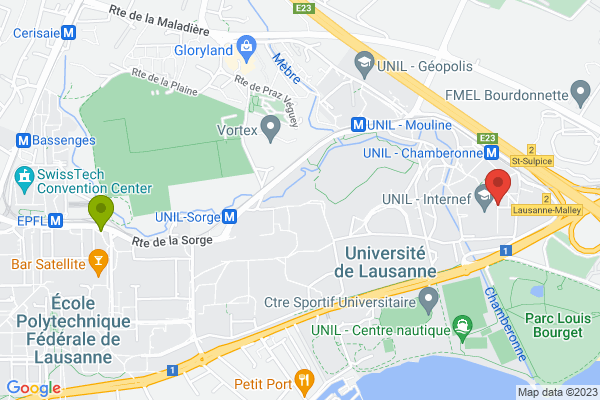

In [ ]:
import requests
from PIL import Image
from io import BytesIO

origin = "46.522640908185, 6.584987401404577"
destination = "46.521880860162064, 6.567944879588675"
mode = "bicycling"
key = "yourKey"

#the curly braces are replaced by the variable values at runtime, using f-string
url = f"https://maps.googleapis.com/maps/api/staticmap?size=600x400&maptype=roadmap&markers=color:red%7C{origin}&markers=color:green%7C{destination}&key={key}"

response = requests.get(url)

#With the library "Image", we can convert the byte content into an image
img = Image.open(BytesIO(response.content))
img.show()



Still, the directions from origin to destination are missing and we would like to show a line that follow the path that our bikers have to take.

For that we cannot only use Static Maps, as it is only able to trace a straight line. However, the Directions Maps API could help because it contains the data of the path, based on the mode (bicycling) that we chose.

In [ ]:
pip install polyline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Using the "polyline" library, we can retrieve a list of (latitude, longitude) pairs and use that list in the Static Maps API to add the path within the map image.

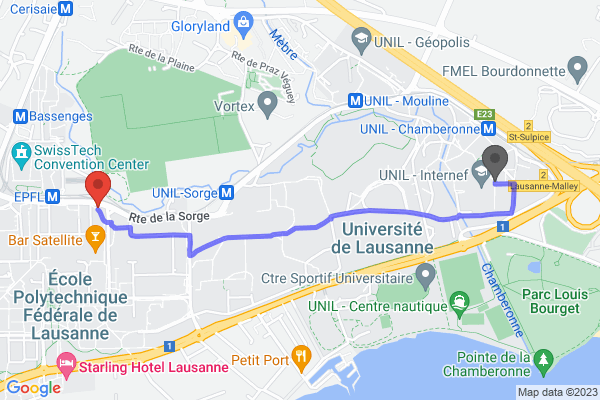

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import polyline

origin = "46.522640908185, 6.584987401404577"
destination = "46.521880860162064, 6.567944879588675"
mode = "bicycling"
key = "yourKey"

# Make a request to the Directions API to get the polyline
directions_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&mode={mode}&key={key}"
directions_response = requests.get(directions_url)
polyline_points = directions_response.json()["routes"][0]["overview_polyline"]["points"]

# Decode the polyline into a list of latitudes and longitudes
decoded_polyline = polyline.decode(polyline_points)

# Create a path parameter with the encoded polyline
encoded_polyline = polyline.encode(decoded_polyline)
path_param = f"enc:{encoded_polyline}"

# Create the URL for the static map with the path parameter
url = f"https://maps.googleapis.com/maps/api/staticmap?size=600x400&maptype=roadmap&markers=color:black%7C{origin}&markers=color:red%7C{destination}&path=color:0x0000ff|weight:5|{path_param}&key={key}"

# Get the image from the URL and display it
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.show()

### First option
Make it work through our Core2 device
Now, we need to use micropython to retrieve (latitude, longitude) coordinates and make a request with the API used above. Then we need to display that image on our device.

Trying to directly generate the image inside the m5Stack core2 device seems to complicate as we get only blank screen when compiling the following code

In [ ]:
import urequests
from m5stack import *
from m5ui import *
from uiflow import *
import ubinascii
import ujson
import polyline

def get_image(url):
    response = urequests.get(url)
    return response.content

def display_image(image_data):
    img = imageData(image_data)
    lcd.image(0, 0, img)

origin = "46.522640908185, 6.584987401404577"
destination = "46.521880860162064, 6.567944879588675"
mode = "bicycling"
key = "yourKey"

# Make a request to the Directions API to get the polyline
directions_url = "https://maps.googleapis.com/maps/api/directions/json?origin=" + origin + "&destination=" + destination + "&mode=" + mode + "&key=" + key
directions_response = urequests.get(directions_url)
polyline_points = ujson.loads(directions_response.text)["routes"][0]["overview_polyline"]["points"]

# Decode the polyline into a list of latitudes and longitudes
decoded_polyline = polyline.decode(polyline_points)

# Create a path parameter with the encoded polyline
encoded_polyline = polyline.encode(decoded_polyline)
path_param = "enc:" + encoded_polyline

# Create the URL for the static map with the path parameter
url = "https://maps.googleapis.com/maps/api/staticmap?size=320x240&maptype=roadmap&markers=color:black%7C" + origin + "&markers=color:red%7C" + destination + "&path=color:0x0000ff|weight:5|" + path_param + "&key=" + key

# Get the image from the URL and display it on the M5Stack Core2
image_data = get_image(url)
display_image(image_data)

### Second option:
A solution step by step to implement a map image into the M5stack core2 as we did not manage to display the image from the buckets in the IoT device.

Step 1: We will use the previous Python function that uses both API to generate the map, in a Google Cloud Function. But we want that function to register a JPEG image of the map into a bucket.

<b>Google Cloud Function</b>

In [ ]:
from google.cloud import storage
import requests
from PIL import Image
from io import BytesIO
import polyline

def generate_map(request):
    if request.method not in ["POST", "PUT"]:
        return "This API only accepts POST and PUT requests"

    # Get the origin, destination, mode, and API key from the request
    origin = request.args.get('origin')
    destination = request.args.get('destination')
    mode = request.args.get('mode')
    key = request.args.get('key')

    if origin is None or destination is None or mode is None or key is None:
        return "One or more required parameters missing"

    # Make a request to the Directions API to get the polyline
    directions_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&mode={mode}&key={key}"
    directions_response = requests.get(directions_url)
    polyline_points = directions_response.json()["routes"][0]["overview_polyline"]["points"]

    # Decode the polyline into a list of latitudes and longitudes
    decoded_polyline = polyline.decode(polyline_points)

    # Create a path parameter with the encoded polyline
    encoded_polyline = polyline.encode(decoded_polyline)
    path_param = f"enc:{encoded_polyline}"

    # Create the URL for the static map with the path parameter
    url = f"https://maps.googleapis.com/maps/api/staticmap?size=600x400&maptype=roadmap&markers=color:black%7C{origin}&markers=color:red%7C{destination}&path=color:0x0000ff|weight:5|{path_param}&key={key}"

    # Get the image from the URL and convert it to RGB mode
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    # Save the image to a file in JPEG format
    img_file_name = 'map_image.jpg'
    img.save(img_file_name, 'JPEG')

    # Upload the image file to Google Cloud Storage
    storage_client = storage.Client()
    bucket_name = 'maps_bucket'
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(img_file_name)
    blob.upload_from_filename(img_file_name)

    # Delete the local image file
    os.remove(img_file_name)

Let's test our Cloud function, with a put request on Python

In [1]:
import requests

url = 'https://generate-maps-qwe4lw44bq-uc.a.run.app'
params = {
    'origin': '46.522640908185, 6.584987401404577',
    'destination': '46.521880860162064, 6.567944879588675',
    'mode': 'bicycling',
    'key': 'yourKey'
}

response = requests.put(url, params=params)

Now let's test it from the IoT device. As the urequests library does not work the same than the requests from Python, we got errors when trying to execute the MicroPython code that corresponded to the one above.
For now, we have our map image in the bucket on GCP but cannot display it directly.
Of course, if we download it locally, we can display it but that's not the idea.

###Third option:
Instead of using an image, let's use the relevant data.

Here is the data contained in the polyline that retrieved the informations directly from the Directions Maps API.

In [ ]:
#Here is the pairs (latitude, longitude) what will be used to define the "path" parameter of Static Map
print (decoded_polyline[0:10])
print (decoded_polyline[-1])

[(46.52264, 6.58496), (46.52259, 6.58496), (46.5226, 6.58541), (46.5226, 6.58579), (46.52254, 6.58578), (46.52197, 6.58574), (46.52173, 6.58566), (46.52171, 6.58498), (46.52169, 6.58465), (46.52166, 6.58436)]
(46.52184, 6.56791)


<b> But we want to retrieve specific information from the responses of the Directions API. </b>

In [ ]:
directions_response.content

Display the content in a more easily readable way.

In [ ]:
import requests
import json

origin = "46.522640908185, 6.584987401404577"
destination = "46.521880860162064, 6.567944879588675"
mode = "bicycling"
key = "yourKey"

# Make a request to the Directions API to get the polyline
directions_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&mode={mode}&key={key}"
directions_response = requests.get(directions_url)

# Pretty-print the response content
print(json.dumps(json.loads(directions_response.content), indent=4))

Once we chose an origin and a destination, we want to extract precise information about the steps in between:
- the distance between each step
- the duration between each step
- precise if there is a maneuver to make at that point

In [ ]:
import requests
import json

origin = "46.522640908185, 6.584987401404577"
destination = "46.521880860162064, 6.567944879588675"
mode = "bicycling"
key = "yourKey"

# Make a request to the Directions API to get the polyline
directions_url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin}&destination={destination}&mode={mode}&key={key}"
directions_response = requests.get(directions_url)

# Parse the response content as JSON
directions_data = json.loads(directions_response.content)

step_info = []
for step in directions_data["routes"][0]["legs"][0]["steps"]:
    distance = step["distance"]["text"]
    duration = step["duration"]["text"]
    maneuver = step.get("maneuver", "N/A")
    start_lat = round(step["start_location"]["lat"], 5)
    start_lng = round(step["start_location"]["lng"], 5)
    step_info.append((distance, duration, maneuver, start_lat, start_lng))
step_info

[('5 m', '1 min', 'N/A', 46.52264, 6.58496),
 ('64 m', '1 min', 'turn-left', 46.52259, 6.58496),
 ('0.1 km', '1 min', 'turn-right', 46.5226, 6.58579),
 ('0.2 km', '1 min', 'turn-right', 46.52173, 6.58566),
 ('13 m', '1 min', 'turn-left', 46.52168, 6.58343),
 ('0.4 km', '2 mins', 'turn-right', 46.52159, 6.58331),
 ('8 m', '1 min', 'turn-left', 46.52163, 6.57791),
 ('0.4 km', '1 min', 'turn-right', 46.52156, 6.57792),
 ('0.1 km', '1 min', 'turn-slight-left', 46.52099, 6.57335),
 ('67 m', '1 min', 'turn-right', 46.52048, 6.57186),
 ('0.2 km', '1 min', 'turn-left', 46.52108, 6.57186),
 ('51 m', '1 min', 'turn-left', 46.52131, 6.56931),
 ('25 m', '1 min', 'turn-right', 46.52129, 6.56864),
 ('68 m', '1 min', 'turn-left', 46.52146, 6.56849)]

That previous code was transformed into a Google Cloud function, so we will be able to call it from our IoT device.

<font color = red>To have more details, please refer to the python file"Final_GpsApplication.py" </font> 

#### Allow the bikers to choose their path
Here is the Geocode API who could be used to progress further in our Project. Once it can manage to follow a path that has been manually defined (as we did in our final MicroPython file), the next step would be to add an input interface in our IoT that will take the users'inputs as coordinates to generate a new path.

In [ ]:
import requests
import json

def get_coordinates(address):
    api_key = "yourKey"  # Replace with your actual API key
    url = "https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}".format(address, api_key)
    
    response = requests.get(url)
    data = json.loads(response.text)
    print (response.status_code)
    
    if data["status"] == "OK":
        result = data["results"][0]
        location = result["geometry"]["location"]
        lat = location["lat"]
        lng = location["lng"]
        return "{}, {}".format(lat, lng)
    else:
        return None

# Example usage
address = "1600 Amphitheatre Parkway, Mountain View, CA"
coordinates = get_coordinates(address)
if coordinates:
    print("Coordinates: {}".format(coordinates))
else:
    print("Failed to get coordinates.")

200
Failed to get coordinates.


# Utilization of M5 Remote+

Here, we use the network address at which the m5stack core2 device send the information
We are using a block of Remote+ that executes periodically when a callback is done on the network address, so we'll use that to make a get request with the input we want to display

#### <b> Defining functions to be able :</b>
1) to get informations from a URL generated by the IoT API

2) to send direct data in a specific block, using IoT API

In [ ]:
import requests

def get_data_from_iot(url):
  response = requests.get(url)
  json_response = json.loads(response.text)
  try:
    text_to_int = int(json_response['data'])
    return str(text_to_int)
  except:
      pass
  return json_response['data'][1:-1]

def send_data_to_url(url, valueToSend):
  value_to_send_formated = str(url) + '(%27' + str(valueToSend).replace(' ','%20') + '%27)'
  requests.get(value_to_send_formated)

In [ ]:
# Define the IoT API endpoint and device ID
api_endpoint = "https://api.m5stack.com/v1/FF66DC60/call"

# Test
# Extract the latitude from the first step in the step_info data
start_lat = step_info[0][3]
url_latitude = f"{api_endpoint}?func=input_nextLatitude_callback(%27{start_lat}%27)"

# Send the IoT API request using HTTP GET
response_lat = requests.get(url_latitude)
#response = requests.get('https://api.m5stack.com/v1/FF66DC60/call?func=input_nextLatitude_callback(%27{}%27)'.format(start_lat))

# Print the response status code
print(response_lat.status_code)

405


#### Now, we call the value of our currently measured latitude (by the GPS unit)

In [ ]:
#To test and replace next one with that if works
api_endpoint = "https://api.m5stack.com/v1/FF66DC60/call?func="
function_name = "label_remotename"
url_nextLatitude = f"{api_endpoint}{function_name}_callback()"

get_data_from_iot(url_nextLatitude)

In [ ]:
response_currentLatitude = requests.get("https://api.m5stack.com/v1/FF66DC60/call?func=label_remotename_callback()")
# Parse the response content as JSON
response_data = json.loads(response_currentLatitude.content)

# Extract the latitude value as a string
latitude_str = response_data["data"]

# Convert the latitude string to a float
latitude = float(latitude_str)

# Print the latitude value
print(latitude)

We want to display distance, duration and potential maneuver once the measured latitude = starting latitude

In [ ]:
import requests

# Extract the informations to show once the bikers reached the destination
informations = step_info[0][0:3]
text="Informations: "
for info in informations:
  text = text + ", " + info

# Send the IoT API request using HTTP GET
response_informations = requests.get('https://api.m5stack.com/v1/FF66DC60/call?func=input_ShowInformation_callback(%27{}%27)'.format(text))

# Print the response status code
print(response_informations.status_code)

400


'Informations: , 5 m, 1 min, N/A'

###Create a Google Cloud Function
Aim at publishing the steps information into a Pub/Sub Client
//finally not used

In [ ]:
import base64
import json
from google.cloud import pubsub_v1

def publish_step_info(request):
    # Get the step_info data from the HTTP POST request
    step_info = request.get_json()

    # Create a Pub/Sub client and topic
    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path("projectiot-380815", "topicTest")

    # Publish the step_info data to the topic
    data = json.dumps(step_info).encode("utf-8")
    future = publisher.publish(topic_path, data=data)

    return "Step info published to Pub/Sub topic."